# Color Image Processing
Colour conveys significant information in an image. For example in processing remote sensing imagery, we may be interested in extacting information on vegetation from colour. The colour we perceive as humans depends on the light reflected from an object.

The colour spectrum can be divided into six broad categories with each blending smoothly into the next. The categories are violet, blue, green, yellow, orange, and red.

The three quantities used to characterise chromatic light are 
1. Radiance  (W)- energy flowing from a light source
2. Luminance (lumens) - energy the observer perceives 
3. Brightness - a subjective measure related to intensity

## Colour Models
Colour models allow the specification of colour in a standard way. They consist of a coordinate system and a subspace within that system. Each colour is a point in the subspace. Examples include the 
1. Red, Green and Blue (RGB) - colour monitors. These are the three primary colours and have the following wavelengths  blue (435.8 nm), green (546.1nm) and red (700nm)
2. Cyan, Magenta, Yellow (CMY) and Cyan, Magenta, Yellow  and Black (CMYK) - colour printing
3. Hue, Saturation and Intensity (HSI) - close to human perception

Hue is associated with the dominate wavelength in a mixture of light wavelengths. Saturation is the proportion of white mixed into the hue. Intensity is related to the subjective measure of brightness. The HSV colour model decouples colour and intensity information making it useful for image processing.

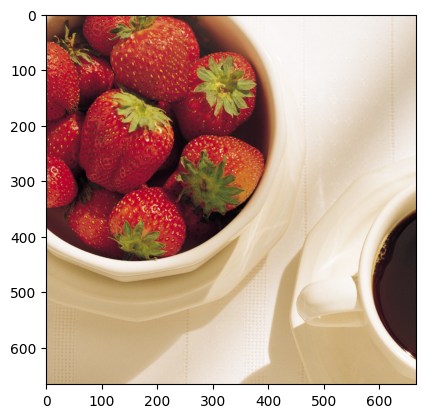

In [1]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
import matplotlib.image as img

image = img.imread("img/strawberry.tif")
plt.imshow(image)
plt.show()

# RGB
We can separate the RGB image into its three components/channels.

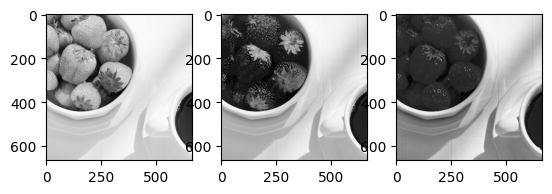

In [2]:
R = image[:,:,0]
G = image[:,:,1]
B = image[:,:,2]


plt.subplot(1, 3, 1)
plt.imshow(R, cmap='gray')

plt.subplot(1, 3, 2)
plt.imshow(G, cmap='gray')

plt.subplot(1, 3, 3)
plt.imshow(B, cmap='gray')

# HSI
To separate an image into Hue, Saturation, and Intensity components, we first begin by converting it from RGB to HSI colour space. After the conversion, we can split into the components.

In [3]:
image_rgb = cv.imread('img/strawberry.tif')
image_rgb = cv.cvtColor(image_rgb, cv.COLOR_BGR2RGB)  # Convert from BGR to RGB

# Convert RGB to HSI
image_hsi = cv.cvtColor(image_rgb, cv.COLOR_RGB2HSV)

# Split the HSI image into separate channels
H, S, I = cv.split(image_hsi)


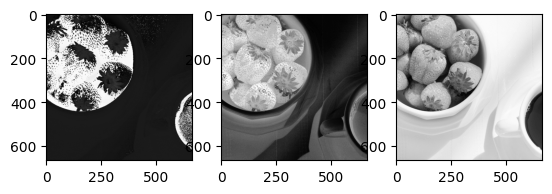

In [4]:
plt.subplot(1, 3, 1)
plt.imshow(H, cmap='gray')

plt.subplot(1, 3, 2)
plt.imshow(S, cmap='gray')

plt.subplot(1, 3, 3)
plt.imshow(I, cmap='gray')

## Image Smoothing & Sharpening
We can smooth a colour image using an averaging filter by applying the kernel to each of the R, G, and B components indepedently and stacking the results. Mathematically, the result of filtering a colour image $\bar{c}(x,y)$ using an averaging filter operating on some neighbourhood $S_{xy}$ is:

\begin{equation}
    \bar{\mathbf{c}}(x,y) = \begin{bmatrix}
        \frac{1}{K} \sum_{(s,t)\in S_{xy}} R(s,t) \\
        \frac{1}{K} \sum_{(s,t)\in S_{xy}} G(s,t) \\
        \frac{1}{K} \sum_{(s,t)\in S_{xy}} B(s,t)
    \end{bmatrix}
\end{equation}

Computing the Laplacian of a colour image $\bar{c}(x,y)$ is done by computing each component's Laplacian and then stacking the reslts together

\begin{equation} 
    \nabla^2 [\mathbf{c}(x,y)] = \begin{bmatrix} 
        \nabla^2 R(x,y) \\ 
        \nabla^2 G(x,y) \\ 
        \nabla^2 B(x,y) 
    \end{bmatrix} 
\end{equation}

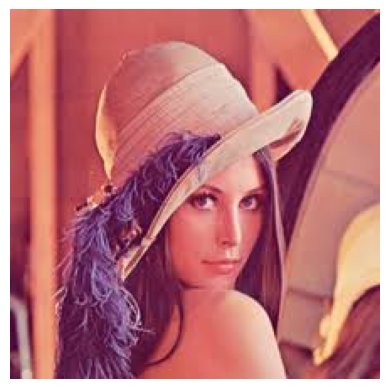

In [5]:
lena = cv.imread('img/lena.jpg')
lena = cv.cvtColor(lena, cv.COLOR_BGR2RGB)  # Convert from BGR to RGB

plt.figure()
plt.imshow(lena), plt.axis('off')
plt.show()

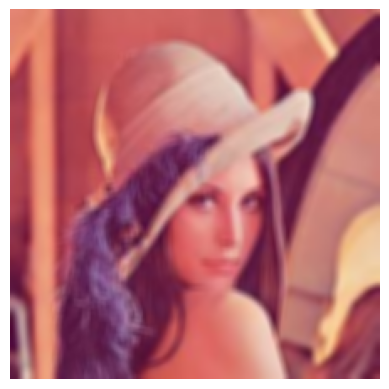

In [6]:
avg_kernel = np.ones((5, 5)) / 25

r, g, b = cv.split(lena)
r_filt = cv.filter2D(src=r, ddepth=-1, kernel=avg_kernel)
g_filt = cv.filter2D(src=g, ddepth=-1, kernel=avg_kernel)
b_filt = cv.filter2D(src=b, ddepth=-1, kernel=avg_kernel)

lena_filt = cv.merge([r_filt, g_filt, b_filt])

plt.figure()
plt.imshow(lena_filt), plt.axis('off')
plt.show()

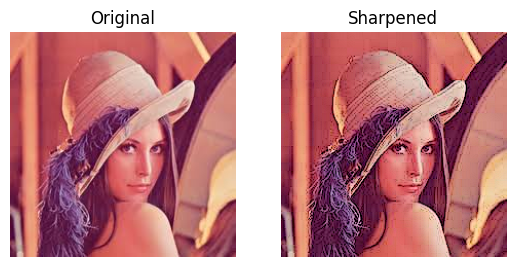

In [7]:
m = 3
kernel = np.zeros((m, m))
kernel[1,1] = -4
kernel[0,1] = 1
kernel[1,0] = 1
kernel[1,2] = 1
kernel[2,1] = 1

lena2 = lena.astype(np.float32)
r, g, b = cv.split(lena2)

def sharpen_channel(channel, kernel):
    '''Sharpens a single channel of a colour image using some kernel'''
    ch_filt = cv.filter2D(src=channel, ddepth=-1, kernel=kernel)
    ch_filt_clip = np.clip(ch_filt, 0, 255).astype(np.uint8)
    ch_sharp = np.clip(channel - ch_filt_clip, a_min=0, a_max=None)
    
    return ch_sharp

r_sharp = sharpen_channel(r, kernel)
g_sharp = sharpen_channel(g, kernel)
b_sharp = sharpen_channel(b, kernel)

sharpened = cv.merge([r_sharp, g_sharp, b_sharp]).astype(np.uint8)

plt.figure()
plt.subplot(121), plt.imshow(lena, 'gray'), plt.axis('off'), plt.title("Original")
plt.subplot(122), plt.imshow(sharpened, 'gray'), plt.axis('off'), plt.title("Sharpened")
plt.show()

# Image segmentation
Segmentation is a process that partitions an image into regions. It can be effectively achieved in HSI or RGB space. We illustrate this using a drone image captured in a forest. We would like to segment tree crowns.

## In HSI space
We examine the hue and saturation of the image and note that it has relatively low values of hue. We create a mask by selecting pixels whose normalised hue is below $0.4$. This does a reasonable job of detecting the tree crowns.

In [8]:
image_rgb = cv.imread('img/drone-segment.jpg')
image_rgb = cv.cvtColor(image_rgb, cv.COLOR_BGR2RGB)  # Convert from BGR to RGB

# Convert RGB to HSI
image_hsi = cv.cvtColor(image_rgb, cv.COLOR_RGB2HSV)

# Split the HSI image into separate channels
H, S, I = cv.split(image_rgb)

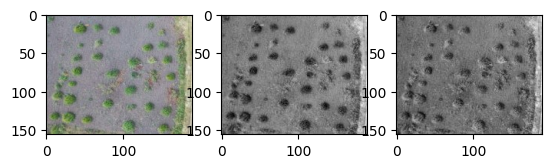

In [9]:
plt.subplot(1, 3, 1)
plt.imshow(image_rgb)

plt.subplot(1, 3, 2)
plt.imshow(H, cmap='gray')

plt.subplot(1, 3, 3)
plt.imshow(S, cmap='gray')

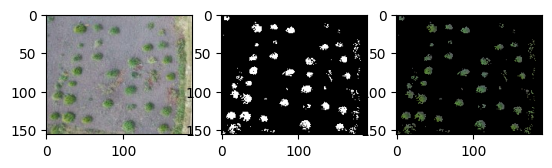

In [10]:
threshold = .4
crowns_hsi = np.zeros_like(image_rgb)

for i in range(image_rgb.shape[0]):
    for j in range(image_rgb.shape[1]):
        crowns_hsi[i,j,:] = (H[i,j] / 255) < threshold


plt.subplot(1, 3, 1)
plt.imshow(image_rgb)

plt.subplot(1, 3, 2)
plt.imshow(crowns_hsi * 255, cmap='gray')

plt.subplot(1, 3, 3)
plt.imshow(np.multiply(image_rgb, crowns_hsi), cmap='gray')

## In RGB space
Here we determine the mean and standard pixel value in a small bounding box capturing a tree crown for the three colour channels. We then determine all pixels that are within $1.25$ standard deviations of the mean. This process is the equivalent of creating a sphere of radius $D_0$ in the RGB space where $D_0 = 1.25\sigma$ where $\sigma$ is the standard deviation of pixel values in the crown image. The centre of the sphere is the mean of pixels in this same crown image. Refer to last slide of the section "Image Segmentation in RGB Space" in the notes for more on this.

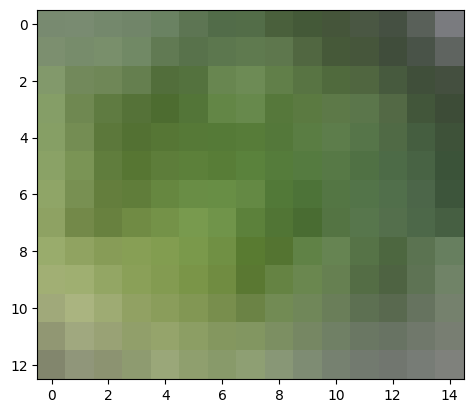

In [11]:
crown_rgb = cv.imread('img/crown-bb.jpg')
crown_rgb = cv.cvtColor(crown_rgb, cv.COLOR_BGR2RGB)  # Convert from BGR to RGB

plt.imshow(crown_rgb)
plt.show()

In [12]:
r_mean = np.mean(crown_rgb[:,:,0])
g_mean = np.mean(crown_rgb[:,:,1])
b_mean = np.mean(crown_rgb[:,:,2])

r_std = np.std(crown_rgb[:,:,0])
g_std = np.std(crown_rgb[:,:,1])
b_std = np.std(crown_rgb[:,:,2])

In [13]:
print(r_mean, g_mean, b_mean)
centre = np.array([r_mean, g_mean, b_mean])
stds = np.array([r_std, g_std, b_std])
upper_lim = centre + 1.25 * stds
lower_lim = centre - 1.25 * stds

104.06666666666666 127.50256410256411 80.86666666666666


In [14]:
crowns_rgb = np.zeros_like(image_rgb)
for i in range(image_rgb.shape[0]):
    for j in range(image_rgb.shape[1]):
        crowns_rgb[i,j,:] = (np.all(image_rgb[i,j,:] < upper_lim) and np.all(image_rgb[i,j,:] > lower_lim)).astype(int)*np.ones(3)

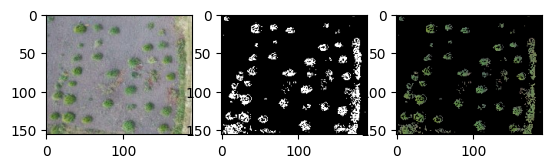

In [15]:
plt.subplot(1, 3, 1)
plt.imshow(image_rgb)

plt.subplot(1, 3, 2)
plt.imshow(crowns_rgb * 255, cmap='gray')

plt.subplot(1, 3, 3)
plt.imshow(np.multiply(image_rgb, crowns_rgb), cmap='gray')

# Morphological Operations
The masks produced in image segmentation can be improved by morphological operations. We will focus on erosion and dilation.

Morphological operations have images as both input and output. There are two main components in morphological operations, a set $A$ and a structuring element $B$. If $A$ is a region within a binary image, the set $A$ consists of elements in $\mathbb{Z}^2$. 

The erosion of $A$ by $B$ is defined as 

\begin{equation}
A\ominus B= \{z|(B)_z  \subseteq A\}
\end{equation}

where 

\begin{equation}
(B)_z= \{c|c=b+z,  b\in B\}
\end{equation}


The dilation of $A$ by $B$ is defined as 

\begin{equation}
A\oplus B= \{z|(\hat{B})_z\cap A \neq \emptyset\}
\end{equation}

Let us see the result of eroding and dilating the mask created above.


In [16]:
kernel_size = 3
kernel = np.ones((kernel_size, kernel_size), np.uint8) 
crown_dilate = cv.dilate(crowns_rgb, kernel, iterations=1) 


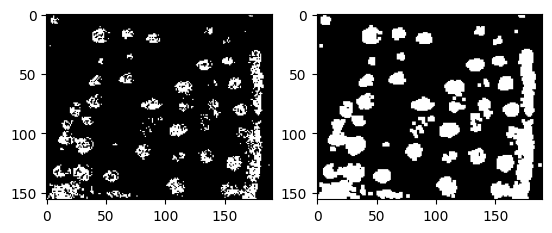

In [17]:
plt.subplot(1, 2, 1)
plt.imshow(crowns_rgb * 255)

plt.subplot(1, 2, 2)
plt.imshow(crown_dilate * 255, cmap='gray')

We can then erode this

In [18]:
crown_dilate_erode = cv.erode(crown_dilate, kernel, iterations=1) 


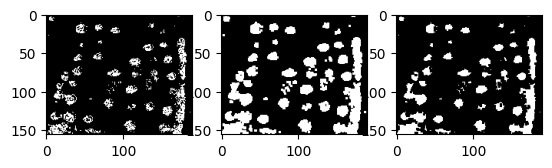

In [19]:
plt.subplot(1, 3, 1)
plt.imshow(crowns_rgb * 255)

plt.subplot(1, 3, 2)
plt.imshow(crown_dilate * 255, cmap='gray')

plt.subplot(1, 3, 3)
plt.imshow(crown_dilate_erode * 255, cmap='gray')